In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
import torch
from torch.nn import LayerNorm

In [6]:
layer = LayerNorm((32,32,24*24))
layer(torch.rand(12, 32, 32, 24*24))

tensor([[[[-7.6055e-01, -4.0590e-01,  1.1318e+00,  ..., -1.4157e+00,
            1.4787e-01,  5.1804e-01],
          [-4.9503e-01,  1.5271e+00,  1.4535e+00,  ..., -8.2681e-01,
           -1.0312e+00,  1.0764e+00],
          [ 2.7770e-01, -1.7206e+00, -2.6204e-01,  ...,  1.1975e+00,
            1.2006e+00, -1.4109e+00],
          ...,
          [-2.8253e-01, -1.5067e+00, -1.5844e+00,  ...,  7.1049e-01,
            3.1727e-01, -1.5858e-01],
          [-1.6799e+00, -6.2662e-01, -8.2630e-01,  ...,  6.0339e-01,
           -5.9868e-01,  9.3045e-02],
          [ 1.3442e+00, -8.1121e-01,  1.3329e+00,  ...,  1.3166e+00,
            5.0551e-01,  4.8784e-01]],

         [[-1.3228e+00,  1.4791e+00,  1.6798e+00,  ...,  1.4491e+00,
            1.4719e-01,  9.9461e-02],
          [ 1.0803e+00, -1.7078e+00,  1.2236e+00,  ...,  6.7004e-01,
            1.2456e+00, -2.4360e-01],
          [-1.9806e-01, -8.3606e-01,  1.5460e+00,  ..., -1.1752e+00,
            1.0096e+00,  7.7244e-02],
          ...,
     

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape((48,48))
#         print('X: ', X.shape)
        
#         X = np.resize(X, (64,64))
#         print('X: ', X.shape)
        
#         X = X.reshape((64,64,1))
#         print('X: ', X.shape)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

            X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 64

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
#     transforms.Grayscale(num_output_channels=3),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
images, labels = iter(train_loader).next()


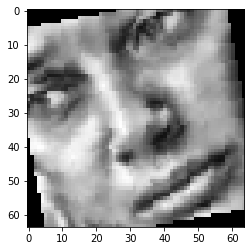

In [6]:
plt.imshow(images[15][0], cmap='gray')

## Residual Masking

The codes are taken from [this repo]('https://github.com/phamquiluan/ResidualMaskingNetwork)

In [7]:
import copy
import torch
import torch.nn as nn

from utils import load_state_dict_from_url
from resnet import BasicBlock, Bottleneck, ResNet, resnet18


model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-5c106cde.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-333f7ec4.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
}


from masking import masking


class ResMasking(ResNet):
    def __init__(self, in_channels=3, weight_path=None):
        super(ResMasking, self).__init__(
            block=BasicBlock, layers=[2, 2, 2, 2], in_channels=in_channels, num_classes=1000
        )
        # state_dict = torch.load('saved/checkpoints/resnet18_rot30_2019Nov05_17.44')['net']
    
        if not weight_path is None:
            state_dict = load_state_dict_from_url(model_urls[weight_path])
            self.load_state_dict(state_dict)

        self.fc = nn.Linear(512, 7)

        """
        # freeze all net
        for m in self.parameters():
            m.requires_grad = False
        """

        self.mask1 = masking(64, 64, depth=4)
        self.mask2 = masking(128, 128, depth=3)
        self.mask3 = masking(256, 256, depth=2)
        self.mask4 = masking(512, 512, depth=1)

    def forward(self, x):  # 224
        x = self.conv1(x)  # 112
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 56

        x = self.layer1(x)  # 56
        m = self.mask1(x)
        x = x * (1 + m)
        # x = x * m

        x = self.layer2(x)  # 28
        m = self.mask2(x)
        x = x * (1 + m)
        # x = x * m

        x = self.layer3(x)  # 14
        m = self.mask3(x)
        x = x * (1 + m)
        # x = x * m

        x = self.layer4(x)  # 7
        m = self.mask4(x)
        x = x * (1 + m)
        # x = x * m

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.fc(x)
        return x


class ResMasking50(ResNet):
    def __init__(self, weight_path):
        super(ResMasking50, self).__init__(
            block=Bottleneck, layers=[3, 4, 6, 3], in_channels=3, num_classes=1000
        )
        # state_dict = torch.load(weight_path)['net']
        state_dict = load_state_dict_from_url(model_urls["resnet50"], progress=True)
        self.load_state_dict(state_dict)

        self.fc = nn.Linear(2048, 7)

        """
        # freeze all net
        for m in self.parameters():
            m.requires_grad = False
        """

        self.mask1 = masking(256, 256, depth=4)
        self.mask2 = masking(512, 512, depth=3)
        self.mask3 = masking(1024, 1024, depth=2)
        self.mask4 = masking(2048, 2048, depth=1)

    def forward(self, x):  # 224
        x = self.conv1(x)  # 112
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 56

        x = self.layer1(x)  # 56
        m = self.mask1(x)
        x = x * (1 + m)

        x = self.layer2(x)  # 28
        m = self.mask2(x)
        x = x * (1 + m)

        x = self.layer3(x)  # 14
        m = self.mask3(x)
        x = x * (1 + m)

        x = self.layer4(x)  # 7
        m = self.mask4(x)
        x = x * (1 + m)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.fc(x)
        return x


# def resmasking(in_channels, num_classes, weight_path='saved/checkpoints/resnet18_rot30_2019Nov05_17.44'):
#     return ResMasking(weight_path)


def resmasking(in_channels, num_classes, weight_path=""):
    return ResMasking(weight_path)


def resmasking50_dropout1(in_channels, num_classes, weight_path=""):
    model = ResMasking50(weight_path)
    model.fc = nn.Sequential(nn.Dropout(0.4), nn.Linear(2048, num_classes))
    return model


def resmasking_dropout1(in_channels=3, num_classes=7, weight_path=""):
    model = ResMasking(weight_path)
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(512, 7)
        # nn.Linear(512, num_classes)
    )
    return model


def resmasking_dropout2(in_channels, num_classes, weight_path=""):
    model = ResMasking(weight_path)

    model.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(128, 7),
    )
    return model


def resmasking_dropout3(in_channels, num_classes, weight_path=""):
    model = ResMasking(weight_path)

    model.fc = nn.Sequential(
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(512, 128),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(128, 7),
    )
    return model


def resmasking_dropout4(in_channels, num_classes, weight_path=""):
    model = ResMasking(in_channels, weight_path)

    model.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(128, 128),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(128, 7),
    )
    return model

#### Train from scratch

In [8]:
device = torch.device('cuda')
print(device)

model = resmasking_dropout4(3, 7, weight_path=None)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [9]:
model = model.to(device)

model_path = './resmasking_18_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.8846004009246826 Batch_id=448  Accuracy=24.82: 100%|██████████| 449/449 [01:49<00:00,  4.09it/s]

- Avg.loss: 1.819  | Avg.acc: 0.248


- Avg. val_loss: 1.812  | Avg. val_acc: 0.249


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.7803943157196045 Batch_id=448  Accuracy=25.17: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.813  | Avg.acc: 0.252



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.808  | Avg. val_acc: 0.249
Epoch:  3


Loss=1.8771430253982544 Batch_id=448  Accuracy=25.03: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.806  | Avg.acc: 0.250



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.789  | Avg. val_acc: 0.248
Epoch:  4


Loss=1.7299683094024658 Batch_id=448  Accuracy=27.03: 100%|██████████| 449/449 [01:49<00:00,  4.08it/s]

- Avg.loss: 1.772  | Avg.acc: 0.270


- Avg. val_loss: 1.692  | Avg. val_acc: 0.310


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.5309724807739258 Batch_id=448  Accuracy=31.62: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.683  | Avg.acc: 0.316


- Avg. val_loss: 1.623  | Avg. val_acc: 0.337


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.6657898426055908 Batch_id=448  Accuracy=35.58: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.613  | Avg.acc: 0.356


- Avg. val_loss: 1.530  | Avg. val_acc: 0.413


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.559773564338684 Batch_id=448  Accuracy=38.45: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.552  | Avg.acc: 0.385



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.498  | Avg. val_acc: 0.411
Epoch:  8


Loss=1.484948754310608 Batch_id=448  Accuracy=39.52: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.519  | Avg.acc: 0.395


- Avg. val_loss: 1.466  | Avg. val_acc: 0.422


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.6122020483016968 Batch_id=448  Accuracy=40.08: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.497  | Avg.acc: 0.401


- Avg. val_loss: 1.489  | Avg. val_acc: 0.425


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.5806148052215576 Batch_id=448  Accuracy=40.67: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.480  | Avg.acc: 0.407



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.500  | Avg. val_acc: 0.395
Epoch:  11


Loss=1.455277919769287 Batch_id=448  Accuracy=41.09: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.467  | Avg.acc: 0.411



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.422  | Avg. val_acc: 0.416
Epoch:  12


Loss=1.3582706451416016 Batch_id=448  Accuracy=41.16: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.461  | Avg.acc: 0.412



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.446  | Avg. val_acc: 0.420
Epoch:  13


Loss=1.4043054580688477 Batch_id=448  Accuracy=41.75: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.450  | Avg.acc: 0.417


- Avg. val_loss: 1.494  | Avg. val_acc: 0.429


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.5977641344070435 Batch_id=448  Accuracy=42.22: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.444  | Avg.acc: 0.422



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.427  | Avg. val_acc: 0.426
Epoch:  15


Loss=1.5157065391540527 Batch_id=448  Accuracy=41.77: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.442  | Avg.acc: 0.418



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.463  | Avg. val_acc: 0.410
Epoch:  16


Loss=1.4506165981292725 Batch_id=448  Accuracy=42.18: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.433  | Avg.acc: 0.422



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.415  | Avg. val_acc: 0.422
Epoch:  17


Loss=1.3391008377075195 Batch_id=448  Accuracy=42.17: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.432  | Avg.acc: 0.422


- Avg. val_loss: 1.477  | Avg. val_acc: 0.436


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.473655343055725 Batch_id=448  Accuracy=42.53: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.432  | Avg.acc: 0.425


- Avg. val_loss: 1.395  | Avg. val_acc: 0.453


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.4651460647583008 Batch_id=448  Accuracy=42.61: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.427  | Avg.acc: 0.426



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.435  | Avg. val_acc: 0.431
Epoch:  20


Loss=1.5032306909561157 Batch_id=448  Accuracy=43.74: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.415  | Avg.acc: 0.437


- Avg. val_loss: 1.385  | Avg. val_acc: 0.457


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=1.4182813167572021 Batch_id=448  Accuracy=43.91: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.416  | Avg.acc: 0.439


- Avg. val_loss: 1.400  | Avg. val_acc: 0.466


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=1.4467418193817139 Batch_id=448  Accuracy=45.16: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.411  | Avg.acc: 0.452



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.410  | Avg. val_acc: 0.435
Epoch:  23


Loss=1.68290114402771 Batch_id=448  Accuracy=45.42: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]  

- Avg.loss: 1.404  | Avg.acc: 0.454


- Avg. val_loss: 1.351  | Avg. val_acc: 0.472


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=1.2945281267166138 Batch_id=448  Accuracy=46.40: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.393  | Avg.acc: 0.464


- Avg. val_loss: 1.363  | Avg. val_acc: 0.486


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=1.5505212545394897 Batch_id=448  Accuracy=46.51: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.391  | Avg.acc: 0.465



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.350  | Avg. val_acc: 0.473
Epoch:  26


Loss=1.1471370458602905 Batch_id=448  Accuracy=46.72: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.376  | Avg.acc: 0.467



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.339  | Avg. val_acc: 0.477
Epoch:  27


Loss=1.3592782020568848 Batch_id=448  Accuracy=47.27: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.365  | Avg.acc: 0.473


- Avg. val_loss: 1.344  | Avg. val_acc: 0.490


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=1.1124203205108643 Batch_id=448  Accuracy=47.58: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.371  | Avg.acc: 0.476


- Avg. val_loss: 1.326  | Avg. val_acc: 0.495


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=1.608291506767273 Batch_id=448  Accuracy=48.12: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.360  | Avg.acc: 0.481


- Avg. val_loss: 1.333  | Avg. val_acc: 0.501


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=1.422451376914978 Batch_id=448  Accuracy=48.24: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.360  | Avg.acc: 0.482


- Avg. val_loss: 1.310  | Avg. val_acc: 0.512


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=1.34679114818573 Batch_id=448  Accuracy=48.18: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]  

- Avg.loss: 1.353  | Avg.acc: 0.482



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.326  | Avg. val_acc: 0.500
Epoch:  32


Loss=1.532423496246338 Batch_id=448  Accuracy=48.63: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s] 

- Avg.loss: 1.352  | Avg.acc: 0.486



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.355  | Avg. val_acc: 0.502
Epoch:  33


Loss=1.1654201745986938 Batch_id=448  Accuracy=48.47: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.348  | Avg.acc: 0.485



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.329  | Avg. val_acc: 0.511
Epoch:  34


Loss=1.5176708698272705 Batch_id=448  Accuracy=48.95: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.345  | Avg.acc: 0.489



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.297  | Avg. val_acc: 0.511
Epoch:  35


Loss=1.4368889331817627 Batch_id=448  Accuracy=48.75: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.340  | Avg.acc: 0.488



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.329  | Avg. val_acc: 0.504
Epoch:  36


Loss=1.1349185705184937 Batch_id=448  Accuracy=49.11: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.338  | Avg.acc: 0.491


- Avg. val_loss: 1.334  | Avg. val_acc: 0.513


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=1.396573543548584 Batch_id=448  Accuracy=49.16: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.335  | Avg.acc: 0.492



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.350  | Avg. val_acc: 0.503
Epoch:  38


Loss=1.393873929977417 Batch_id=448  Accuracy=49.35: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s] 

- Avg.loss: 1.335  | Avg.acc: 0.494



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.340  | Avg. val_acc: 0.507
Epoch:  39


Loss=1.4107632637023926 Batch_id=448  Accuracy=49.29: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.337  | Avg.acc: 0.493



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.286  | Avg. val_acc: 0.508
Epoch:  40


Loss=1.410245656967163 Batch_id=448  Accuracy=49.52: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.332  | Avg.acc: 0.495



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.296  | Avg. val_acc: 0.511
Epoch:  41


Loss=1.2520508766174316 Batch_id=448  Accuracy=49.62: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.329  | Avg.acc: 0.496



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.295  | Avg. val_acc: 0.501
Epoch:  42


Loss=1.5382193326950073 Batch_id=448  Accuracy=49.26: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.332  | Avg.acc: 0.493



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.305  | Avg. val_acc: 0.499
Epoch:  43


Loss=1.2531698942184448 Batch_id=448  Accuracy=49.60: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.326  | Avg.acc: 0.496


- Avg. val_loss: 1.288  | Avg. val_acc: 0.513


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  44


Loss=1.095475435256958 Batch_id=448  Accuracy=49.51: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.325  | Avg.acc: 0.495



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.285  | Avg. val_acc: 0.504
Epoch:  45


Loss=1.0623619556427002 Batch_id=448  Accuracy=50.16: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.319  | Avg.acc: 0.502


- Avg. val_loss: 1.258  | Avg. val_acc: 0.524


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  46


Loss=0.9371217489242554 Batch_id=448  Accuracy=50.05: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.319  | Avg.acc: 0.501



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.266  | Avg. val_acc: 0.512
Epoch:  47


Loss=1.3454782962799072 Batch_id=448  Accuracy=50.49: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.313  | Avg.acc: 0.505



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.278  | Avg. val_acc: 0.514
Epoch:  48


Loss=1.4817148447036743 Batch_id=448  Accuracy=50.05: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.316  | Avg.acc: 0.501



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.263  | Avg. val_acc: 0.524
Epoch:  49


Loss=1.0463227033615112 Batch_id=448  Accuracy=49.97: 100%|██████████| 449/449 [01:50<00:00,  4.05it/s]

- Avg.loss: 1.318  | Avg.acc: 0.500



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.318  | Avg. val_acc: 0.514
Epoch:  50


Loss=1.1526919603347778 Batch_id=448  Accuracy=50.48: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.315  | Avg.acc: 0.505



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.310  | Avg. val_acc: 0.514
Epoch:  51


Loss=1.1887314319610596 Batch_id=448  Accuracy=50.72: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.304  | Avg.acc: 0.507


- Avg. val_loss: 1.311  | Avg. val_acc: 0.529


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  52


Loss=1.4226269721984863 Batch_id=448  Accuracy=50.51: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.312  | Avg.acc: 0.505



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.266  | Avg. val_acc: 0.516
Epoch:  53


Loss=1.2077677249908447 Batch_id=448  Accuracy=50.67: 100%|██████████| 449/449 [01:50<00:00,  4.05it/s]

- Avg.loss: 1.308  | Avg.acc: 0.507



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.292  | Avg. val_acc: 0.513
Epoch:  54


Loss=1.4395341873168945 Batch_id=448  Accuracy=50.33: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.307  | Avg.acc: 0.503



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.260  | Avg. val_acc: 0.515
Epoch    54: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  55


Loss=1.1412004232406616 Batch_id=448  Accuracy=52.12: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.270  | Avg.acc: 0.521


- Avg. val_loss: 1.227  | Avg. val_acc: 0.538


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  56


Loss=1.3584544658660889 Batch_id=448  Accuracy=52.22: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.261  | Avg.acc: 0.522



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.267  | Avg. val_acc: 0.528
Epoch:  57


Loss=1.0769027471542358 Batch_id=448  Accuracy=52.60: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.255  | Avg.acc: 0.526


- Avg. val_loss: 1.224  | Avg. val_acc: 0.538


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  58


Loss=1.3984272480010986 Batch_id=448  Accuracy=52.59: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.256  | Avg.acc: 0.526



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.237  | Avg. val_acc: 0.521
Epoch:  59


Loss=1.3389793634414673 Batch_id=448  Accuracy=52.74: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.249  | Avg.acc: 0.527


- Avg. val_loss: 1.228  | Avg. val_acc: 0.541


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  60


Loss=1.1319583654403687 Batch_id=448  Accuracy=52.70: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.252  | Avg.acc: 0.527


- Avg. val_loss: 1.234  | Avg. val_acc: 0.544


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  61


Loss=1.2865233421325684 Batch_id=448  Accuracy=53.07: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.247  | Avg.acc: 0.531



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.222  | Avg. val_acc: 0.542
Epoch:  62


Loss=1.2252740859985352 Batch_id=448  Accuracy=53.12: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.244  | Avg.acc: 0.531



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.229  | Avg. val_acc: 0.542
Epoch:  63


Loss=1.164771556854248 Batch_id=448  Accuracy=53.32: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.244  | Avg.acc: 0.533



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.224  | Avg. val_acc: 0.532
Epoch:  64


Loss=1.3329325914382935 Batch_id=448  Accuracy=53.25: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.242  | Avg.acc: 0.533



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.236  | Avg. val_acc: 0.542
Epoch:  65


Loss=1.3192720413208008 Batch_id=448  Accuracy=53.20: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.246  | Avg.acc: 0.532



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.218  | Avg. val_acc: 0.530
Epoch:  66


Loss=1.1798124313354492 Batch_id=448  Accuracy=53.04: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.244  | Avg.acc: 0.530



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.236  | Avg. val_acc: 0.531
Epoch:  67


Loss=1.1672642230987549 Batch_id=448  Accuracy=53.35: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.244  | Avg.acc: 0.534



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.224  | Avg. val_acc: 0.544
Epoch:  68


Loss=1.4962753057479858 Batch_id=448  Accuracy=52.84: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.242  | Avg.acc: 0.528



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.222  | Avg. val_acc: 0.536
Epoch:  69


Loss=1.3180335760116577 Batch_id=448  Accuracy=53.35: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.239  | Avg.acc: 0.533



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.235  | Avg. val_acc: 0.536
Epoch:  70


Loss=1.1429455280303955 Batch_id=448  Accuracy=53.17: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.242  | Avg.acc: 0.532


- Avg. val_loss: 1.230  | Avg. val_acc: 0.548


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  71


Loss=1.095980167388916 Batch_id=448  Accuracy=53.50: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.233  | Avg.acc: 0.535



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.208  | Avg. val_acc: 0.538
Epoch:  72


Loss=1.516486406326294 Batch_id=448  Accuracy=53.59: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.236  | Avg.acc: 0.536



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.219  | Avg. val_acc: 0.540
Epoch:  73


Loss=1.117287039756775 Batch_id=448  Accuracy=53.41: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s] 

- Avg.loss: 1.237  | Avg.acc: 0.534



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.256  | Avg. val_acc: 0.531
Epoch:  74


Loss=1.1753008365631104 Batch_id=448  Accuracy=53.84: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.234  | Avg.acc: 0.538



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.226  | Avg. val_acc: 0.534
Epoch:  75


Loss=1.3652480840682983 Batch_id=448  Accuracy=53.81: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.225  | Avg.acc: 0.538



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.193  | Avg. val_acc: 0.547
Epoch:  76


Loss=1.1560033559799194 Batch_id=448  Accuracy=53.57: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.228  | Avg.acc: 0.536



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.205  | Avg. val_acc: 0.546
Epoch:  77


Loss=1.1657007932662964 Batch_id=431  Accuracy=54.18:  96%|█████████▌| 431/449 [01:46<00:04,  4.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.350656270980835 Batch_id=448  Accuracy=54.15: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s] 

- Avg.loss: 1.220  | Avg.acc: 0.541



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.191  | Avg. val_acc: 0.551
Epoch:  87


Loss=1.2166744470596313 Batch_id=448  Accuracy=54.00: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.221  | Avg.acc: 0.540



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.192  | Avg. val_acc: 0.553
Epoch:  88


Loss=1.4579228162765503 Batch_id=448  Accuracy=54.80: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s]

- Avg.loss: 1.213  | Avg.acc: 0.548



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.199  | Avg. val_acc: 0.544
Epoch:  89


Loss=1.212785005569458 Batch_id=448  Accuracy=54.57: 100%|██████████| 449/449 [01:50<00:00,  4.07it/s] 

- Avg.loss: 1.214  | Avg.acc: 0.546



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.175  | Avg. val_acc: 0.551
Epoch:  90


Loss=1.153844952583313 Batch_id=134  Accuracy=55.13:  30%|███       | 135/449 [00:34<01:16,  4.08it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.3136119842529297 Batch_id=448  Accuracy=54.50: 100%|██████████| 449/449 [01:50<00:00,  4.06it/s]

- Avg.loss: 1.211  | Avg.acc: 0.545


- Avg. val_loss: 1.169  | Avg. val_acc: 0.566
Epoch    99: reducing learning rate of group 0 to 1.0000e-03.


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  100


Loss=0.9479662775993347 Batch_id=448  Accuracy=55.30: 100%|██████████| 449/449 [01:50<00:00,  4.08it/s]

- Avg.loss: 1.190  | Avg.acc: 0.553


- Avg. val_loss: 1.162  | Avg. val_acc: 0.558
Finished Training


([<matplotlib.lines.Line2D at 0x7f92b2914f28>,
 0.5656171635553079)

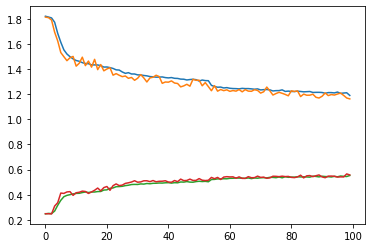

In [11]:
pickle.dump(hist, open('resmasking_18_hist.hdf5', 'wb'))
plt.plot(hist), best_acc

In [12]:
# EVALUATE
model = torch.load('resmasking_18_model.pt')
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.152  | Avg. val_acc: 0.559


In [10]:
import torch
import torch.nn as nn

In [30]:
a = torch.rand(12, 32, 32, 24, 24)
a = a.view(-1, 1, 32*24, 32*24)
a.size()

torch.Size([12, 1, 768, 768])

In [31]:
conv = nn.Conv2d(1, 1, kernel_size=24, stride=24, padding=False)
conv(a).size()

torch.Size([12, 1, 32, 32])